# Lab 6: Transfer Learning

In the lab, we are going to train an object detection CNN 
using Transfer Learning. The idea is to start from your 
lab 5 network and re-use it to speed up the training 
on a new dataset.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [2]:
# Import the necessary modules

import keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation 
from tensorflow.keras.layers import PReLU, LeakyReLU, Conv2D, Lambda, MaxPooling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [3]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
def save_top_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = top_model.to_json()
    with open("top_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    top_model.save_weights("top_model.h5")
    print("Saved top_model to top_model.json and weights to top_model.h5")

def save_finetuned_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = finetuned_model.to_json()
    with open("finetuned_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    finetuned_model.save_weights("finetuned_model.h5")
    print("Saved model to finetuned_model.json and weights to finetuned_model.h5")



# Loading the new dataset (cifar100)

We are going to use the 10 first classes of the cifar100 dataset.
https://www.cs.toronto.edu/~kriz/cifar.html

> This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).


In [4]:
!curl --create-dirs -o /home/tcd/data/cifar100-dataset.pkl http://4c16.ml/~mindfreeze/cifar100-dataset.pkl


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  6446k      0  0:00:02  0:00:02 --:--:-- 6443k


loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


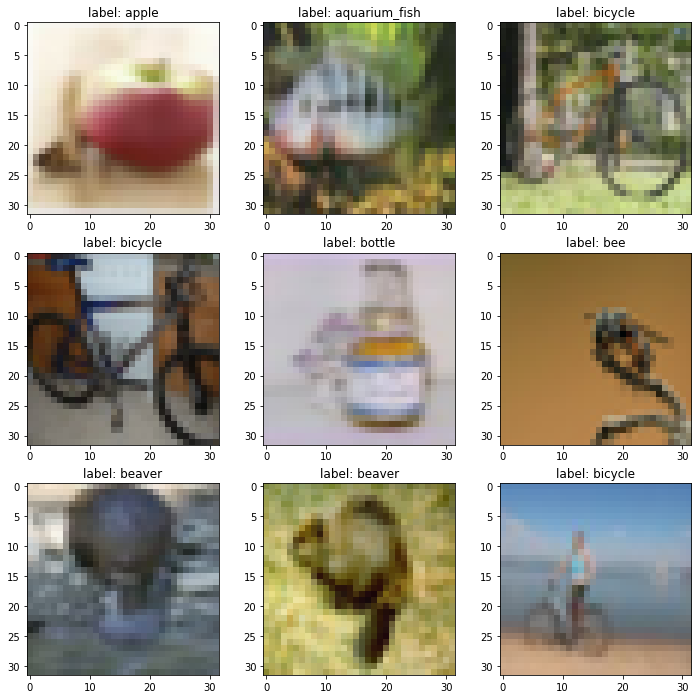

In [5]:
# Loading new dataset cifar100

print('loading the dataset...')

pkl_file = open('/home/tcd/data/cifar100-dataset.pkl', 'rb')
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5 
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [6]:
# training / validation split
X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

## Loading the Base Network

Our starting point will be to take your CNN network from Lab 5 
and use it for building visual features for the images of our new dataset.
So let's start with re-loading your network. 

You don't need to retrain your network but you can if you want. If you do, note that Also, 
note that we probably don't need a very long training. The idea of this lab 
is only to show that you can get a good kick start from lab 5's network.


In [7]:
pwd


'/content/gdrive/MyDrive/4c16-labs/code/lab-06'

In [8]:
# Here we assume that you have already successfully completed Lab 5 
# and trained a CNN on cifar10

# load json and create base_model
with open('../lab-05/model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
base_model = model_from_json(loaded_model_json)
# load weights into base_model
base_model.load_weights("../lab-05/model.h5")
# print the model summary

In [9]:
base_model.summary()

# In the summary, take note of the Layer names in the first column
# eg. conv2d_6 (Conv2D) means that 'conv2d_6' will be the name for 
# that layer

# In preparation for the next step, You also need to check that 
# shape of the Flatten layer is small enough. Typically we want something
# like (None, 2048). You don't want (None, 40000).

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_142 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_143 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_115 (Dropout)       (None, 16, 16, 64)        0         
                                                                 
 conv2d_144 (Conv2D)         (None, 16, 16, 128)       73856     
                                                          

# Part 1: Using the Base Network to Build Visual Features

In this first part we are going to directly use the base model to pre-compute 
visual features on this new dataset. For this, we are going to compute the predictions 
for the intermediate `Flatten` layer.

In [10]:
# change the `flatten_2` name to the corresponding name from your network

# TODO: create model to predict the features at 'flatten' layer

features_model = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('flatten_27').output)
train_features = features_model.predict(X_train)
validation_features = features_model.predict(X_validation)


# checking that everything is ok, you should get a tensor of size 4500 x Flatten Size
# eg. (4500, 2048)
print(train_features.shape)



16/16 [==============================] - 2s 119ms/step
(4500, 4096)


In [11]:
# now that you have computed the new features for your dataset,
# you need to design a simple classification network.
# For good measure, use one with BatchNormalization, dropout, etc. 
# and train it.


inputs = keras.layers.Input(shape=train_features.shape[1:]) 
# TODO: complete the network ....
x = Dense(512, activation = 'relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation='softmax')(x)


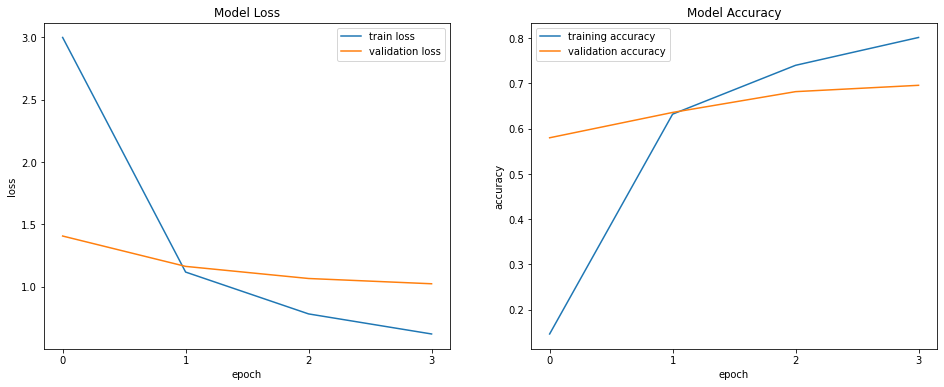

2/2 [==============================] - 1s 271ms/step - loss: 0.6210 - accuracy: 0.8018 - val_loss: 1.0235 - val_accuracy: 0.6960


In [12]:
# now we can compile it and train it.

top_model = keras.models.Model(inputs=inputs, outputs=predictions)

top_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

top_model.summary()

# TODO: write code to train it ...

# the dataset is very small and the base_model gives us a very good 
# starting point, so we only need a handful of epochs, probably 1 
# or 2 will do.
num_epochs = 4

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
top_model.fit(train_features, Y_train,
          batch_size=4096, epochs=num_epochs, 
          validation_data=(validation_features, Y_validation), 
          callbacks=[pltCallBack])



In [13]:
# write model to top_model.json and weights to top_model.h5 for submission
# you'll need to get about 65% accuracy to get full marks

save_top_model_to_disk()

Saved top_model to top_model.json and weights to top_model.h5


# Part 2: Fine-Tuning the Base Network

In this part, instead of pre-computing the visual features, 
we are going to load the base model, freeze the weights for the convolutional layers and allow the optimizer to fine-tune the classification dense layers. This is done by setting the flag
`trainable` to `True` or `False` in the network layers.


In [14]:
finetuned_model = keras.models.clone_model(base_model)

# set the all the layers in model to trainable = False

# set the all the layers in model to trainable = False
for layer in finetuned_model.layers:
    layer.trainable = False

# TODO: then set all the layers after the Flatten layer to be trainable

finetuned_model.layers[14].trainable = True
finetuned_model.layers[16].trainable = True
finetuned_model.layers[18].trainable = True
finetuned_model.layers[19].trainable = True

for layer in finetuned_model.layers:
   print(layer, layer.trainable)

   


<keras.engine.input_layer.InputLayer object at 0x7f0692eb3ed0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0692dcedd0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f069cfa5810> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0693041050> False
<keras.layers.regularization.dropout.Dropout object at 0x7f0692ef45d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0692ef4ed0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f069d0b4f90> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0692eea0d0> False
<keras.layers.regularization.dropout.Dropout object at 0x7f06930aaf10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f069d0d5a90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0692ef42d0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f069ca94850> False
<keras.layers.regularization.dropout.Dropout object at 0x7f0692f4d350> False
<keras.layers

In [15]:

# TODO compile model 

# model.compile(...)
opt = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
finetuned_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.summary()
finetuned_model.summary()
# loading the pre-trained weights from your lab-05 network
finetuned_model.load_weights("../lab-05/model.h5")



Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_142 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_143 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_115 (Dropout)       (None, 16, 16, 64)        0         
                                                                 
 conv2d_144 (Conv2D)         (None, 16, 16, 128)       73856     
                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


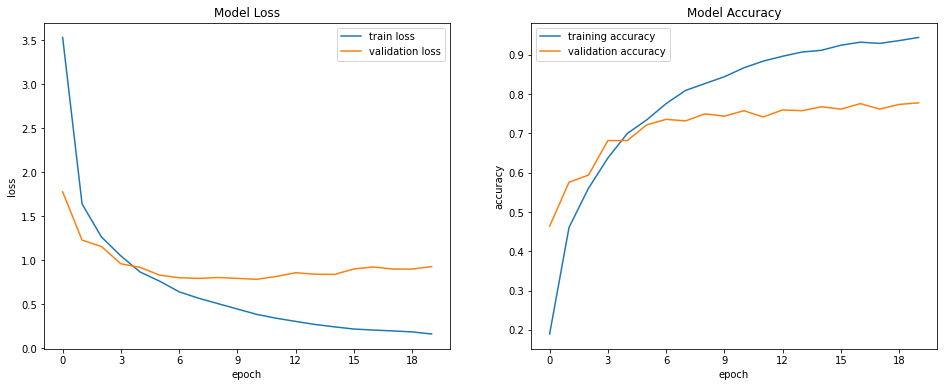

5/5 [==============================] - 20s 4s/step - loss: 0.1621 - accuracy: 0.9444 - val_loss: 0.9281 - val_accuracy: 0.7780


In [16]:
# TODO train 'model' on (X_train, Y_train) for 10 or so epochs  
# What you should be able to observe is that the training is a bit slower than
# in the previous case. This is partly because we haven't re-initialised the weights.

num_epochs = 20

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
finetuned_model.fit(X_train, Y_train,
          batch_size=1024, epochs=num_epochs, 
          validation_data=(X_validation, Y_validation), 
          callbacks=[pltCallBack])


In [17]:
# write model to model.json and weights to model.h5 for submission
# you'll need to get 75% accuracy to get full marks

save_finetuned_model_to_disk()

Saved model to finetuned_model.json and weights to finetuned_model.h5
